# Odhad CDPF

## Cíl analýzy

Cílem analýzy je odhad neoklasické agregátní CDPF.

## Data a metoda

Pro odhad byly použity následující hodnoty:

- hrubá přidaná hodnota (Gross Value Added) (převedená na stálé ceny roku 2010 pomocí deflátoru HDP),
- čistý fixní nefinanční kapitál (převedený na stálé ceny roku 2010 pomocí deflátoru kapitálových zásob),
- celkový počet odpracovaných hodin.

In [587]:
import eurostat
import pandas
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as ts
import numpy
import seaborn
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

LOCATIONS = ["AT", "BE", "CZ", "DE", "DK", "ES", "FR", "HU", "IT", "NL", "PL", "PT", "SK", "SI"]
BASE_LOCATION = "FR"
START_YEAR = 1995
END_YEAR = 2019

### Hrubá přidaná hodnota (Gross Value Added)

Hrubá přidaná hodnota je načtena na základě kódu `nama_10_a10`.

In [588]:
data_1_es = eurostat.get_data_df('nama_10_a10')

In [589]:
data_1 = data_1_es
# Value added, gross
data_1 = data_1[data_1["na_item"].isin(["B1G", "D1"])]
# Total, all NACE activities
data_1 = data_1[data_1["nace_r2"] == "TOTAL"]
# Current prices, million euro
data_1 = data_1[data_1["unit"].isin(["CP_MNAC", "PD10_NAC"])]
data_1 = pandas.melt(data_1, id_vars=["unit", "na_item", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                     value_name="value", var_name="year")
data_1 = data_1.pivot(index=["geo\\time", "year"], columns=["unit", "na_item"], values="value")
data_1.columns = ['_'.join(col) for col in data_1.columns.values]
data_1 = data_1.reset_index()
data_1 = data_1.rename({"CP_MNAC_B1G": "gross_value_added", "CP_MNAC_D1": "employees_compensations",
                        "PD10_NAC_B1G": "gross_value_added_deflator"}, axis=1)
data_1["gross_value_added"] = data_1["gross_value_added"] / (data_1["gross_value_added_deflator"] / 100)
data_1["employees_compensations"] = data_1["employees_compensations"] / (data_1["gross_value_added_deflator"] / 100)
data_1 = data_1.dropna()
data_1

,geo\time,year,gross_value_added,employees_compensations,gross_value_added_deflator
25,AT,1995,1.938137e+05,109894.441394,81.945
26,AT,1996,1.975044e+05,110344.986145,82.641
27,AT,1997,2.016516e+05,111310.653407,83.363
28,AT,1998,2.095363e+05,115226.919118,83.554
29,AT,1999,2.163266e+05,119202.922776,83.756
...,...,...,...,...,...
1095,UK,2015,1.601774e+06,869804.277454,106.886
1096,UK,2016,1.628161e+06,885659.191675,109.164
1097,UK,2017,1.656569e+06,904613.035081,111.315
1098,UK,2018,1.678851e+06,921265.918459,113.783


Pro data provedeme logaritmizaci a určíme hodnoty diferencí.

In [590]:
data_1 = data_1.sort_values(["geo\\time", "year"])
data_1["ln_gross_value_added"] = numpy.log(data_1["gross_value_added"])
data_1["ln_employees_compensations"] = numpy.log(data_1["employees_compensations"])
data_1["ln_gross_value_added_t_minus_1"] = data_1.groupby("geo\\time")["ln_gross_value_added"].shift(1)
data_1["ln_employees_compensations_t_minus_1"] = data_1.groupby("geo\\time")["ln_employees_compensations"].shift(1)
data_1["ln_gross_value_added_diff"] = data_1["ln_gross_value_added"] - data_1["ln_gross_value_added_t_minus_1"]
data_1["ln_employees_compensations_diff"] = data_1["ln_employees_compensations"] - data_1["ln_employees_compensations_t_minus_1"]
data_1["ln_gross_value_added_diff_perc"] = (data_1["ln_gross_value_added"] - data_1["ln_gross_value_added_t_minus_1"]) / data_1["ln_gross_value_added"]
data_1

,geo\time,year,gross_value_added,employees_compensations,gross_value_added_deflator,ln_gross_value_added,ln_employees_compensations,ln_gross_value_added_t_minus_1,ln_employees_compensations_t_minus_1,ln_gross_value_added_diff,ln_employees_compensations_diff,ln_gross_value_added_diff_perc
25,AT,1995,1.938137e+05,109894.441394,81.945,12.174652,11.607276,NaN,NaN,NaN,NaN,NaN
26,AT,1996,1.975044e+05,110344.986145,82.641,12.193516,11.611367,12.174652,11.607276,0.018864,0.004091,0.001547
27,AT,1997,2.016516e+05,111310.653407,83.363,12.214297,11.620080,12.193516,11.611367,0.020781,0.008713,0.001701
28,AT,1998,2.095363e+05,115226.919118,83.554,12.252653,11.654659,12.214297,11.620080,0.038356,0.034578,0.003130
29,AT,1999,2.163266e+05,119202.922776,83.756,12.284545,11.688583,12.252653,11.654659,0.031892,0.033924,0.002596
...,...,...,...,...,...,...,...,...,...,...,...,...
1095,UK,2015,1.601774e+06,869804.277454,106.886,14.286622,13.676023,14.264811,13.655964,0.021811,0.020059,0.001527
1096,UK,2016,1.628161e+06,885659.191675,109.164,14.302962,13.694087,14.286622,13.676023,0.016340,0.018064,0.001142
1097,UK,2017,1.656569e+06,904613.035081,111.315,14.320259,13.715263,14.302962,13.694087,0.017297,0.021175,0.001208
1098,UK,2018,1.678851e+06,921265.918459,113.783,14.333620,13.733504,14.320259,13.715263,0.013361,0.018241,0.000932


Dále načteme informace o odpracovaných hodinách, které mají kód `nama_10_a10_e`.

In [591]:
data_2_es = eurostat.get_data_df('nama_10_a10_e')

In [592]:
data_2 = data_2_es
# Total employment domestic concept
data_2 = data_2[data_2["na_item"] == "EMP_DC"]
# Total, all NACE activities
data_2 = data_2[data_2["nace_r2"] == "TOTAL"]
# Thousands hours worked
data_2 = data_2[data_2["unit"] == "THS_HW"]
data_2 = pandas.melt(data_2, id_vars=["unit", "na_item", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                    value_name="thousands_hours_worked", var_name="year")
data_2 = data_2.sort_values(["geo\\time", "year"])
data_2 = data_2.dropna()
data_2["ln_thousands_hours_worked"] = numpy.log(data_2["thousands_hours_worked"])
data_2["ln_thousands_hours_worked_t_minus_1"] = data_2.groupby("geo\\time")["ln_thousands_hours_worked"].shift(1)
data_2["ln_thousands_hours_worked_diff"] = data_2["ln_thousands_hours_worked"] - data_2["ln_thousands_hours_worked_t_minus_1"]
data_2["ln_thousands_hours_worked_diff_perc"] = (data_2["ln_thousands_hours_worked"] - data_2["ln_thousands_hours_worked_t_minus_1"]) / data_2["ln_thousands_hours_worked"]
data_2 = data_2[["geo\\time", "year", "ln_thousands_hours_worked", "ln_thousands_hours_worked_diff", "ln_thousands_hours_worked", "ln_thousands_hours_worked_diff_perc"]]
data_2

,geo\time,year,ln_thousands_hours_worked,ln_thousands_hours_worked_diff,ln_thousands_hours_worked,ln_thousands_hours_worked_diff_perc
0,AT,1995,15.666346,NaN,15.666346,NaN
39,AT,1996,15.688559,0.022213,15.688559,0.001416
78,AT,1997,15.700493,0.011934,15.700493,0.000760
117,AT,1998,15.698566,-0.001927,15.698566,-0.000123
156,AT,1999,15.715818,0.017252,15.715818,0.001098
...,...,...,...,...,...,...
817,UK,2015,17.763948,0.006727,17.763948,0.000379
856,UK,2016,17.787589,0.023640,17.787589,0.001329
895,UK,2017,17.796454,0.008865,17.796454,0.000498
934,UK,2018,17.805025,0.008571,17.805025,0.000481


Jako předposlední krok je načten čistý fixní nefinanční kapitál, který má kód `nama_10_nfa_bs`.

In [593]:
data_3_es = eurostat.get_data_df('nama_10_nfa_bs')

In [594]:
data_3 = data_3_es
data_3 = eurostat.get_data_df('nama_10_nfa_bs')
# Total fixed assets (net)
data_3 = data_3[data_3["asset10"] == "N11N"]
# Total, all activities
data_3 = data_3[data_3["sector"] == "S1"]
# Current fixed prices, millions of national currency
data_3 = data_3[data_3["unit"] == "CP_MNAC"]
data_3 = pandas.melt(data_3, id_vars=["unit", "asset10", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                    value_name="total_fixed_assets", var_name="year")
data_3 = data_3.sort_values(["geo\\time", "year"])
data_3 = data_3.dropna()
data_3

,unit,asset10,geo\time,year,total_fixed_assets
0,CP_MNAC,N11N,AT,1995,630857.8
29,CP_MNAC,N11N,AT,1996,659084.4
58,CP_MNAC,N11N,AT,1997,686219.3
87,CP_MNAC,N11N,AT,1998,710697.9
116,CP_MNAC,N11N,AT,1999,737295.8
...,...,...,...,...,...
608,CP_MNAC,N11N,UK,2015,3858861.0
637,CP_MNAC,N11N,UK,2016,4035923.0
666,CP_MNAC,N11N,UK,2017,4241207.0
695,CP_MNAC,N11N,UK,2018,4450882.0


V posledním kroku je načten deflátor kapitálových zásob, který má kód `nama_10_nfa_fl`.

In [595]:
data_4_es = eurostat.get_data_df('nama_10_nfa_fl')

In [596]:
data_4 = data_4_es
data_4 = data_4[data_4["asset10"] == "N11G"]
data_4 = data_4[data_4["nace_r2"] == "TOTAL"]
data_4 = data_4[data_4["unit"] == "PD10_NAC"]
data_4 = pandas.melt(data_4, id_vars=["unit", "asset10", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                    value_name="capital_stock_deflator", var_name="year")
data_4 = data_4.sort_values(["geo\\time", "year"])
data_4 = data_4.dropna()
data_4

,unit,asset10,geo\time,year,capital_stock_deflator
0,PD10_NAC,N11G,AT,1995,79.960
32,PD10_NAC,N11G,AT,1996,80.723
64,PD10_NAC,N11G,AT,1997,81.648
96,PD10_NAC,N11G,AT,1998,82.293
128,PD10_NAC,N11G,AT,1999,82.710
...,...,...,...,...,...
671,PD10_NAC,N11G,UK,2015,109.387
703,PD10_NAC,N11G,UK,2016,111.824
735,PD10_NAC,N11G,UK,2017,114.704
767,PD10_NAC,N11G,UK,2018,117.000


Hodnota kapitálu je nyní převedena na stálé ceny roku 2010.

In [597]:
data_3 = data_3.merge(data_4, on=["geo\\time", "year"])
data_3["total_fixed_assets"] = data_3["total_fixed_assets"] / data_3["capital_stock_deflator"]
data_3["ln_total_fixed_assets"] = numpy.log(data_3["total_fixed_assets"])
data_3["ln_total_fixed_assets_t_minus_1"] = data_3.groupby("geo\\time")["ln_total_fixed_assets"].shift(1)
data_3["ln_total_fixed_assets_diff"] = data_3["ln_total_fixed_assets"] - data_3["ln_total_fixed_assets_t_minus_1"]
data_3["ln_total_fixed_assets_diff_perc"] = (data_3["ln_total_fixed_assets"] - data_3["ln_total_fixed_assets_t_minus_1"]) / data_3["ln_total_fixed_assets"]
data_3 = data_3[["geo\\time", "year", "ln_total_fixed_assets", "ln_total_fixed_assets_diff", "ln_total_fixed_assets_diff_perc"]]
data_3

,geo\time,year,ln_total_fixed_assets,ln_total_fixed_assets_diff,ln_total_fixed_assets_diff_perc
0,AT,1995,8.973309,NaN,NaN
1,AT,1996,9.007583,0.034274,0.003805
2,AT,1997,9.036535,0.028952,0.003204
3,AT,1998,9.063717,0.027181,0.002999
4,AT,1999,9.095404,0.031687,0.003484
...,...,...,...,...,...
673,UK,2015,10.470991,0.011359,0.001085
674,UK,2016,10.493819,0.022829,0.002175
675,UK,2017,10.518004,0.024184,0.002299
676,UK,2018,10.546439,0.028435,0.002696


In [598]:
data = pandas.merge(data_1, data_2, on=["geo\\time", "year"])
data = pandas.merge(data, data_3, on=["geo\\time", "year"])
data = data.dropna()
data

,geo\time,year,gross_value_added,employees_compensations,gross_value_added_deflator,ln_gross_value_added,ln_employees_compensations,ln_gross_value_added_t_minus_1,ln_employees_compensations_t_minus_1,ln_gross_value_added_diff,ln_employees_compensations_diff,ln_gross_value_added_diff_perc,ln_thousands_hours_worked,ln_thousands_hours_worked_diff,ln_thousands_hours_worked,ln_thousands_hours_worked_diff_perc,ln_total_fixed_assets,ln_total_fixed_assets_diff,ln_total_fixed_assets_diff_perc
1,AT,1996,1.975044e+05,110344.986145,82.641,12.193516,11.611367,12.174652,11.607276,0.018864,0.004091,0.001547,15.688559,0.022213,15.688559,0.001416,9.007583,0.034274,0.003805
2,AT,1997,2.016516e+05,111310.653407,83.363,12.214297,11.620080,12.193516,11.611367,0.020781,0.008713,0.001701,15.700493,0.011934,15.700493,0.000760,9.036535,0.028952,0.003204
3,AT,1998,2.095363e+05,115226.919118,83.554,12.252653,11.654659,12.214297,11.620080,0.038356,0.034578,0.003130,15.698566,-0.001927,15.698566,-0.000123,9.063717,0.027181,0.002999
4,AT,1999,2.163266e+05,119202.922776,83.756,12.284545,11.688583,12.252653,11.654659,0.031892,0.033924,0.002596,15.715818,0.017252,15.715818,0.001098,9.095404,0.031687,0.003484
5,AT,2000,2.246742e+05,121811.185102,84.845,12.322407,11.710227,12.284545,11.688583,0.037862,0.021645,0.003073,15.725506,0.009688,15.725506,0.000616,9.121397,0.025994,0.002850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,UK,2015,1.601774e+06,869804.277454,106.886,14.286622,13.676023,14.264811,13.655964,0.021811,0.020059,0.001527,17.763948,0.006727,17.763948,0.000379,10.470991,0.011359,0.001085
669,UK,2016,1.628161e+06,885659.191675,109.164,14.302962,13.694087,14.286622,13.676023,0.016340,0.018064,0.001142,17.787589,0.023640,17.787589,0.001329,10.493819,0.022829,0.002175
670,UK,2017,1.656569e+06,904613.035081,111.315,14.320259,13.715263,14.302962,13.694087,0.017297,0.021175,0.001208,17.796454,0.008865,17.796454,0.000498,10.518004,0.024184,0.002299
671,UK,2018,1.678851e+06,921265.918459,113.783,14.333620,13.733504,14.320259,13.715263,0.013361,0.018241,0.000932,17.805025,0.008571,17.805025,0.000481,10.546439,0.028435,0.002696


C:\Users\jirip\repos\deotn\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


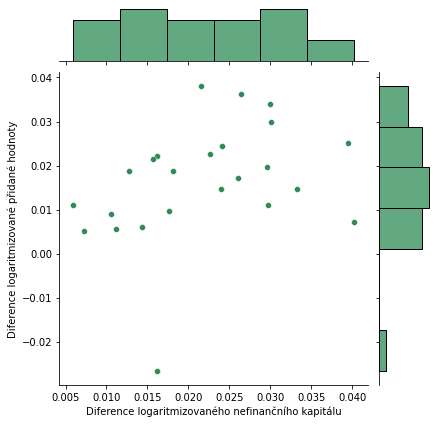

In [599]:
current_data = data[data["geo\\time"] == BASE_LOCATION]
h = seaborn.jointplot("ln_total_fixed_assets_diff", "ln_gross_value_added_diff", current_data, kind='scatter', color='seagreen')
h.set_axis_labels('Diference logaritmizovaného nefinančního kapitálu', 'Diference logaritmizované přidané hodnoty')

Níže je graf vztahu mezi diferencí logaritmovaných odpracovaných hodin a diferencí logaritmované
hrubé přidané hodnoty.
Zde je korelace očividně výrazně slabší.

C:\Users\jirip\repos\deotn\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


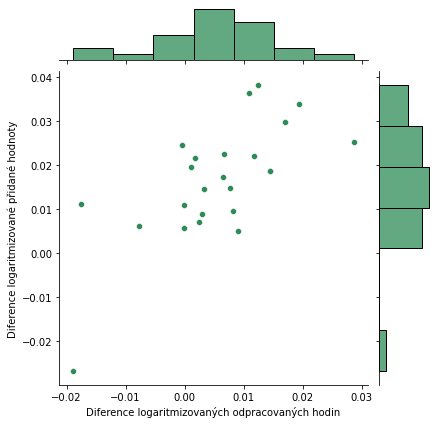

In [600]:
current_data = data[data["geo\\time"] == BASE_LOCATION]
data_plot = data
h = seaborn.jointplot("ln_thousands_hours_worked_diff", "ln_gross_value_added_diff", current_data, kind='scatter', color='seagreen')
h.set_axis_labels('Diference logaritmizovaných odpracovaných hodin', 'Diference logaritmizované přidané hodnoty')


In [601]:
current_data = data
current_data = current_data.rename(columns={"ln_total_fixed_assets_diff": "Diff. log. nefinančního kapitálu", "ln_gross_value_added_diff": "Diff. log. hrubé přidané hodnoty", "ln_thousands_hours_worked_diff": "Diff. log. odpracovaných hodin", "ln_employees_compensations_diff": "Diff. log. mzdových nákladů" })
current_data[["Diff. log. nefinančního kapitálu","Diff. log. hrubé přidané hodnoty", "Diff. log. odpracovaných hodin", "Diff. log. mzdových nákladů"]].corr()

,Diff. log. nefinančního kapitálu,Diff. log. hrubé přidané hodnoty,Diff. log. odpracovaných hodin,Diff. log. mzdových nákladů
Diff. log. nefinančního kapitálu,1.000000,0.448262,0.275038,0.295580
Diff. log. hrubé přidané hodnoty,0.448262,1.000000,0.619651,0.677046
Diff. log. odpracovaných hodin,0.275038,0.619651,1.000000,0.546723
Diff. log. mzdových nákladů,0.295580,0.677046,0.546723,1.000000


In [602]:
current_data = data[data["geo\\time"] == BASE_LOCATION]
result = adfuller(current_data["ln_thousands_hours_worked_diff"])
print(f"p-hodnota testu stacionarity je {result[1]}")
result = adfuller(current_data["ln_gross_value_added_diff"])
print(f"p-hodnota testu stacionarity je {result[1]}")
result = adfuller(current_data["ln_total_fixed_assets_diff"])
print(f"p-hodnota testu stacionarity je {result[1]}")
result = adfuller(current_data["ln_employees_compensations_diff"])
print(f"p-hodnota testu stacionarity je {result[1]}")
result = ts.coint(current_data["ln_gross_value_added_diff"], current_data["ln_thousands_hours_worked_diff"])
print(f"p-hodnota testu kointegrace je {result[1]}")
result = ts.coint(current_data["ln_gross_value_added_diff"], current_data["ln_total_fixed_assets_diff"])
print(f"p-hodnota testu kointegrace je {result[1]}")
result = ts.coint(current_data["ln_gross_value_added_diff"], current_data["ln_employees_compensations_diff"])
print(f"p-hodnota testu kointegrace je {result[1]}")

p-hodnota testu stacionarity je 0.12213665034891474
p-hodnota testu stacionarity je 0.01923537879198988
p-hodnota testu stacionarity je 0.06903047979346275
p-hodnota testu stacionarity je 0.641207439286887
p-hodnota testu kointegrace je 0.028768460630821394
p-hodnota testu kointegrace je 0.012715448419339784
p-hodnota testu kointegrace je 0.0013026646217594842


In [603]:
current_data = data[data["geo\\time"] == "FR"]
mod = smf.ols(formula="ln_gross_value_added_diff ~ ln_employees_compensations_diff + ln_total_fixed_assets_diff", data=current_data)
res = mod.fit()
print(res.params)
res.summary()

Intercept                         -0.000997
ln_employees_compensations_diff    0.872071
ln_total_fixed_assets_diff         0.135422
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     ln_gross_value_added_diff   R-squared:                       0.539
Model:                                   OLS   Adj. R-squared:                  0.495
Method:                        Least Squares   F-statistic:                     12.29
Date:                       Sun, 23 Jan 2022   Prob (F-statistic):           0.000292
Time:                               23:08:54   Log-Likelihood:                 79.454
No. Observations:                         24   AIC:                            -152.9
Df Residuals:                             21   BIC:                            -149.4
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.0010      0.005     -0.193      0.849      -0.012       0.010
ln_employees_compensations_diff     0.8721      0.200      4.359      0.000       0.456       1.288
ln_total_fixed_assets_diff          0.1354      0.223      0.607      0.550      -0.329       0.599
==============================================================================
Omnibus:                        8.970   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.948
Skew:                          -0.649   Prob(JB):                      0.00691
Kurtosis:                       5.874   Cond. No.                         129.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [604]:
current_data = data[data["geo\\time"] == BASE_LOCATION]
mod = smf.ols(formula="ln_gross_value_added_diff ~ ln_thousands_hours_worked_diff + ln_total_fixed_assets_diff", data=current_data)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     ln_gross_value_added_diff   R-squared:                       0.507
Model:                                   OLS   Adj. R-squared:                  0.460
Method:                        Least Squares   F-statistic:                     10.81
Date:                       Sun, 23 Jan 2022   Prob (F-statistic):           0.000591
Time:                               23:08:54   Log-Likelihood:                 78.649
No. Observations:                         24   AIC:                            -151.3
Df Residuals:                             21   BIC:                            -147.8
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.0065      0.005      1.269      0.218      -0.004       0.017
ln_thousands_hours_worked_diff     0.8027      0.198      4.050      0.001       0.391       1.215
ln_total_fixed_assets_diff         0.2560      0.222      1.151      0.263      -0.207       0.719
==============================================================================
Omnibus:                        0.663   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.718   Jarque-Bera (JB):                0.412
Skew:                          -0.310   Prob(JB):                        0.814
Kurtosis:                       2.836   Cond. No.                         120.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [617]:
results_per_countries = []
results_per_countries_alt = []
for current_country in LOCATIONS:
  current_data = data[data["geo\\time"] == current_country]
  mod = smf.ols(formula="ln_gross_value_added_diff ~ ln_employees_compensations_diff + ln_total_fixed_assets_diff", data=current_data)
  res = mod.fit()
  print(current_country)
  print(res.params)
  results_per_countries.append({"country": current_country, "const": res.params[0], "koef L": res.params[1], "koef K": res.params[2], "R_squared": res.rsquared, "R squared adj.": res.rsquared_adj, "t-stat koef L": res.pvalues[1], "t-stat koef K": res.pvalues[2]})
  mod = smf.ols(formula="ln_gross_value_added_diff ~ ln_thousands_hours_worked_diff + ln_total_fixed_assets_diff", data=current_data)
  res = mod.fit()
  print(res.params)
  results_per_countries_alt.append({"country": current_country, "const": res.params[0], "koef L": res.params[1], "koef K": res.params[2], "R_squared": res.rsquared, "R squared adj.": res.rsquared_adj, "t-stat koef L": res.pvalues[1], "t-stat koef K": res.pvalues[2]})

AT
Intercept                         -0.022547
ln_employees_compensations_diff    0.871665
ln_total_fixed_assets_diff         1.161800
dtype: float64
Intercept                        -0.005610
ln_thousands_hours_worked_diff    0.844738
ln_total_fixed_assets_diff        0.836518
dtype: float64
BE
Intercept                         -0.002492
ln_employees_compensations_diff    0.075401
ln_total_fixed_assets_diff         1.000070
dtype: float64
Intercept                        -0.000431
ln_thousands_hours_worked_diff    0.732574
ln_total_fixed_assets_diff        0.596314
dtype: float64
CZ
Intercept                          0.001714
ln_employees_compensations_diff    0.667403
ln_total_fixed_assets_diff         0.118551
dtype: float64
Intercept                         0.014634
ln_thousands_hours_worked_diff    0.656977
ln_total_fixed_assets_diff        0.367055
dtype: float64
DE
Intercept                         -0.005887
ln_employees_compensations_diff    0.752563
ln_total_fixed_assets_diff 

In [618]:
results_per_countries = pandas.DataFrame(results_per_countries)
results_per_countries

,country,const,koef L,koef K,R_squared,R squared adj.,t-stat koef L,t-stat koef K
0,AT,-0.022547,0.871665,1.161800,0.654754,0.621873,1.257411e-04,0.006209
1,BE,-0.002492,0.075401,1.000070,0.347807,0.285693,7.132709e-01,0.023701
2,CZ,0.001714,0.667403,0.118551,0.767625,0.745494,2.979818e-07,0.387199
3,DE,-0.005887,0.752563,0.570203,0.406492,0.349968,5.014192e-03,0.351401
4,DK,-0.001514,0.065488,0.811902,0.578195,0.538023,7.156108e-01,0.000423
5,ES,0.004112,0.652693,0.145683,0.862024,0.844777,7.567296e-07,0.225537
6,FR,-0.000997,0.872071,0.135422,0.539331,0.495458,2.756172e-04,0.550425
7,HU,0.007383,0.644650,0.166042,0.625861,0.590229,1.315010e-05,0.267367
8,IT,-0.002643,1.051596,-0.183131,0.758133,0.727899,3.324797e-06,0.338716
9,NL,0.007017,0.618098,0.076199,0.439537,0.386160,7.096787e-03,0.797355


In [620]:
results_per_countries_alt = pandas.DataFrame(results_per_countries_alt)
results_per_countries_alt



,country,const,koef L,koef K,R_squared,R squared adj.,t-stat koef L,t-stat koef K
0,AT,-0.005610,0.844738,0.836518,0.577641,0.537417,1.155389e-03,0.080454
1,BE,-0.000431,0.732574,0.596314,0.563213,0.521615,3.829966e-03,0.067115
2,CZ,0.014634,0.656977,0.367055,0.302158,0.235697,5.613674e-02,0.115876
3,DE,0.005423,1.390969,0.310544,0.674545,0.643549,6.871380e-06,0.491327
4,DK,0.002705,0.558607,0.536292,0.737516,0.712517,1.680459e-03,0.002153
5,ES,0.009893,0.725823,0.020204,0.955770,0.950241,7.853463e-11,0.772064
6,FR,0.006461,0.802733,0.255995,0.507358,0.460439,5.766745e-04,0.262810
7,HU,0.020325,0.520444,0.198994,0.215803,0.141118,5.187981e-02,0.357812
8,IT,0.003061,1.131474,-0.140058,0.777291,0.749452,1.698931e-06,0.438024
9,NL,0.005258,0.926552,0.272627,0.652493,0.619397,3.596801e-05,0.169574
